# Custom Dissimilarities

This notebook is an example on how to use the tensorflow implementation of the Dissimilarity Mixture Autoencoder (DMAE) with a custom dissimilarity function.

In [1]:
# Required libraries
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib import colors
plt.style.use("ggplot")
%matplotlib inline

# Path of the DMAE library
import sys, itertools
# sys.path.append("/tf/home/repositorios/DMAE/") # how to use the code in other location
sys.path.append("../../")
import DMAE

# Setting random seed
np.random.seed(1)
tf.random.set_seed(1)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# Imporing some helper functions to visualize and understand the results
import vis_utils

## Toroidal Isotropicly Distributed Blobs

First, we're going to define isotropic Gaussian blobs with toroidal properties, the points that are outside of the boundaries $[-1, 1]$ are mirrored on each axis:

Text(0.5, 1.0, 'Generated Data')

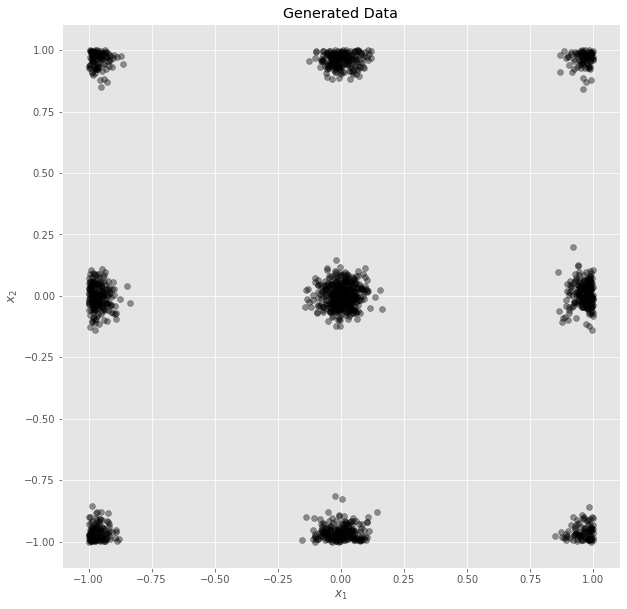

In [2]:
# Number of samples to generate
n_samples = 1600
X, _ = make_blobs(n_samples=n_samples, centers=[(1.0, 0.0), (-1.0, 1.0), (0.0, -1.0), (0, 0)], cluster_std=0.05)
X = np.float32(X)
X[X>1] = X[X>1]-2
X[X<-1] = X[X<-1]+2
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c="k", alpha=0.4)
plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
plt.title("Generated Data")

Now, we define some hyperparameters:

In [3]:
# Number of clusters
n_clusters = 4
# Softmax inverse temperature parameter
alpha = 100
# Training parameters
batch_size = 256
epochs = 200
lr = 1e-3

Let us define an appropriate dissimilarity for this problem. We define the ```toroidal_pairwise``` function, which is a pairwise dissimilarity that measures the squared distance between points and clusters while considering toroidal properties:

In [4]:
def toroidal_dis(x_i, Y, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((x_i-Y)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        d = tf.minimum(tf.reduce_sum((x_i-Y+delta)**2, axis=1), d)
    return d

def toroidal_pairwise(X, Y, interval=tf.constant((1.0, 1.0))):
    func = lambda x_i: toroidal_dis(x_i, Y, interval)
    Z = tf.vectorized_map(func, X)
    return Z

Likewise, we define the loss function for this dissimilarity:

In [5]:
def toroidal_loss(X, mu_tilde, interval=tf.constant((1.0, 1.0))):
    d = tf.reduce_sum((X-mu_tilde)**2, axis=1)
    for val in itertools.product([0.0, 1.0, -1.0], repeat=2):
        delta = tf.constant(val)*interval
        d = tf.minimum(tf.reduce_sum((X-mu_tilde+delta)**2, axis=1), d)
    return d

In [6]:
interval = tf.constant((2.0, 2.0))
dis = lambda X, Y: toroidal_pairwise(X, Y, interval)
dmae_loss = lambda X, mu_tilde: toroidal_loss(X, mu_tilde, interval)

Defining the shallow DMAE model:

In [7]:
inp = tf.keras.layers.Input(shape=(2, ))
# DMM layer
theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoder(alpha=alpha, n_clusters=n_clusters,
                                                          initializers={"centers": DMAE.Initializers.InitPlusPlus(X, n_clusters, dis, 50),
                                                                        "mixers": tf.keras.initializers.Constant(1.0)},
                                                          trainable = {"centers": True, "mixers": False},
                                                          dissimilarity=dis)(inp)
# DMAE model
model = tf.keras.Model(inputs=[inp], outputs=theta_tilde)
model.compile(loss=dmae_loss, optimizer=tf.optimizers.Adam(lr=lr))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Mangled names are not yet supported by AutoGraph
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Mangled names are not yet supported by AutoGraph


Training the model:

In [8]:
model.fit(X, X, epochs=epochs, batch_size=batch_size)

Train on 1600 samples
Epoch 1/200
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.0143
Epoch 2/200
1600/1600 [==============================] - 0s 45us/sample - loss: 0.0126
Epoch 3/200
1600/1600 [==============================] - 0s 48us/sample - loss: 0.0111
Epoch 4/200
1600/1600 [==============================] - 0s 41us/sample - loss: 0.0099
Epoch 5/200
1600/1600 [==============================] - 0s 48us/sample - loss: 0.0088
Epoch 6/200
1600/1600 [==============================] - 0s 47us/sample - loss: 0.0080
Epoch 7/200
1600/1600 [==============================] - 0s 47us/sample - loss: 0.0073
Epoch 8/200
1600/1600 [==============================] - 0s 45us/sample - loss: 0.0067
Epoch 9/200
1600/1600 [==============================] - 0s 44us/sample - loss: 0.0063
Epoch 10/200
1600/1600 [==============================] - 0s 45us/sample - loss: 0.0059
Epoch 11/200
1600/1600 [==============================] - 0s 46us/sample - loss: 0.0057
Epoch 12/200
1600/16

To visualize the results, we define an auxiliar model for the encoder:

In [9]:
inp = tf.keras.layers.Input(shape=(2,))
assigns = DMAE.Layers.DissimilarityMixtureEncoder(alpha=0.1, n_clusters=n_clusters,
                                                  dissimilarity=dis,
                                                  trainable={"centers": False, "mixers": False})(inp)
DMAE_encoder = tf.keras.Model(inputs=[inp], outputs=[assigns])
DMAE_encoder.layers[-1].set_weights(model.layers[1].get_weights())

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Mangled names are not yet supported by AutoGraph
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Mangled names are not yet supported by AutoGraph


Let's see the Voronoi regions:

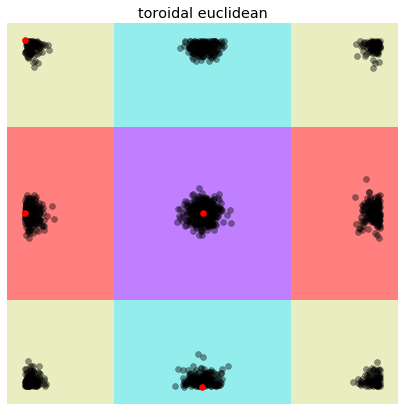

In [10]:
fig, ax = vis_utils.visualize_regions(DMAE_encoder, "toroidal euclidean", X, (7, 7), batch_size)

We can visualize the mixed distribution:

(-1, 1)

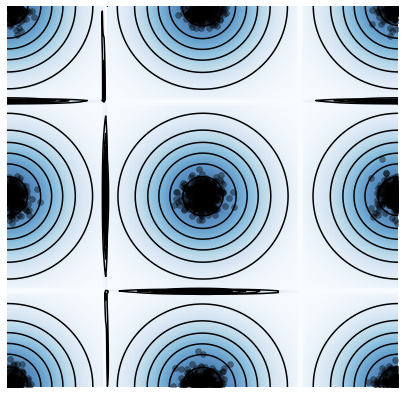

In [11]:
fig, ax = vis_utils.visualize_distribution(model, dmae_loss, 10, X, figsize=(7, 7))
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])